The research: https://www.sciencedirect.com/science/article/pii/S0140988319302798 <br>
Let's look at the research: "Can cross-border transmission expansion lead to fair and stable cooperation? Northeast Asia case analysis" by Andrey Churkin, David Pozo, Janusz Bialeka, Nikolay Korgin and Enzo Sauma

<b>Plan:</b>
1. Formulation of an optimization task
2. Interpretation of the results
3. Modules used

### 1. Formulation of a framework  that involves optimal transmission expansion and cost-beneﬁts allocation

Let's look at the optimization task. 
1. Goal: minimize cost for every scenario out of 63 possible scenarios
2. Key metric: total costs for generating and creating a network
3. Result: key characteristics of the optimal network

In [7]:
## this is a new version of the ASG script in Julia 1.1 based on the "LA case scenarios 1hour 04.09.2019"
using JuMP, Gurobi, Plots
using XLSX

file5=XLSX.readxlsx("ASG data 14.06.2018.xlsx")
Demand0=XLSX.readdata("ASG data 14.06.2018.xlsx", "Curves", "C48:C56")
h=XLSX.readdata("ASG data 14.06.2018.xlsx", "Curves", "C40:C43") 
Seasons=XLSX.readdata("ASG data 14.06.2018.xlsx", "Curves", "B28:E36")
Demand=Seasons.*Demand0 # power consumption by seasons, GW
Nn=9 #number of nodes

###---------------------------------lines & topology----------------------------
Lines=XLSX.readdata("ASG data 14.06.2018.xlsx", "Topology", "A41:H52")
Nl=getindex(size(Lines[:,1]),1) #number of lines considered
#composing an incedence matrix # rows--> nodes, columns --> lines
B=zeros(Nn,Nl)
for i = 1:Nn
    for j = 1:Nl
        if Lines[j,2] == i
            B[i,j]=-1
        elseif Lines[j,3] == i
            B[i,j]=1
        end
    end
end

## Now we create scenarios of interconnections in order to calculate Shapley
Countrieslines=XLSX.readdata("ASG data 14.06.2018.xlsx", "Topology", "C57:N62")
nc=6 #number of countries
X=ones(2^nc-1,Nl) #matrix for possible decisions on lines construction
u=Shapley_matrix(nc) #get the scenarios

for j=1:nc
    for i=1:2^nc-1
            for l=1:Nl
                if floor(Int,u[i,j])==0
                    if floor(Int,Countrieslines[j,l])==1
                        X[i,l]=0 # means this line cannot be built under certain scenario
                    end
                end
            end
    end
end

###---------------------------------Generation----------------------------------

# ---------- use this to break VOM cost function apart --------
    k=20 #number of curves breaking points
    LCOE,Generation=breaking_curves_new_data(k)
    Ntypes=getindex(size(Generation[1,:]),1)
    # Pmax=cat(dims=3,Generation,Generation,Generation) #making 3-dimensional matrix for capacity (nodes,power,season)
# -------------------------------------------------------------

## composing an incedence matrix for generators: rows--> nodes, columns --> type of a genrator
Bgen=zeros(Nn,Ntypes)
for i = 1:Nn
    for j = 1:Ntypes
        if Generation[i,j] > 0
            Bgen[i,j]=1
        end
    end
end

###-----------------------------------------------------------------------------
V=zeros(2^nc-1) #utility funct
TotalCostVector=zeros(2^nc-1)
CountriesGenCost=zeros(2^nc-1,nc)
πlVector=zeros(2^nc-1)
PFres=0
CoalitionLinesCost=zeros(Nl)
Pres=zeros(size(Generation)[2],4)
Pfres=zeros(Nl,4)
PFresVector=zeros(2^nc-1,Nl)

# const GUROBI_ENV = Gurobi.Env()
function solve_model_1(scenario)

SystemOpt = Model()
set_optimizer(SystemOpt, Gurobi.Optimizer)
@variable(SystemOpt, 0<= P[i=1:Nn,n=1:Ntypes,s=1:4]) #actual power of generators, MW
@variable(SystemOpt, Pf[l=1:Nl,s=1:4]) #actual power flows
@variable(SystemOpt, 0<= PF[l=1:Nl]) #power line capacities
@variable(SystemOpt, 0<= πg)# generation cost
@variable(SystemOpt, 0<= πl)# cost for lines
@variable(SystemOpt, x[l=1:Nl], Bin) #line constuction decisions
# @variable(SystemOpt, x[l=1:Nl]) # if I need to check Duals λ

@constraint(SystemOpt, balance[i=1:Nn,s=1:4], sum(P[i,gen,s]*Bgen[i,gen] for gen=1:Ntypes) + sum(B[i,l]*Pf[l,s] for l=1:Nl)  ==  Demand[i,s]*1000) #power balance, MW
@constraint(SystemOpt, [i=1:Nn,gen=1:Ntypes,s=1:4], P[i,gen,s] <= Generation[i,gen])
@constraint(SystemOpt, [l=1:Nl,s=1:4], -PF[l] <=  Pf[l,s])
@constraint(SystemOpt, [l=1:Nl,s=1:4], Pf[l,s] <= PF[l])
@constraint(SystemOpt, [l=1:Nl,s=1:4], PF[l] <= x[l].*Lines[l,7]) #max capacity
@constraint(SystemOpt, [l=1:Nl], x[l] <= X[scenario,l]) #combination of lines per scenario
# @constraint(SystemOpt, x[9] == 1) #Chinese line is built already

@constraint(SystemOpt, πg == sum(sum(sum(P[i,gen,s].*LCOE[i,gen]*1000 for gen=1:Ntypes) for i=1:Nn)*h[s] for s=1:4)) # $/MWyear
@constraint(SystemOpt, πl == sum(PF[l].*Lines[l,8]*1000 for l=1:Nl)) # per MW per 1 year
@objective(SystemOpt, Min, πg + πl) # total expenses per year


                    # TT = STDOUT # save original STDOUT stream (this silences the solver)
                    # redirect_stdout()
        optimize!(SystemOpt)
        #optimize!(SystemOpt, Gurobi.Optimizer) # GUROBI_ENV
                    # redirect_stdout(TT) # restore STDOUT

TotalCost=objective_value.(SystemOpt)
πg=value.(πg)
πl=value.(πl)
println("\n\n")
println("------- scenario # ",scenario," -------")
println("TotalCost = ",TotalCost)
println("πg = ",πg)
println("πl = ",πl)
println("--------------------------")
println("\n\n")
TotalCostVector[scenario]=TotalCost

global Pres=value.(P) #Generation results
global Pfres=value.(Pf) #actual PowerFlows to calculate Energy
global PFres=value.(PF) #PF capacity result
global PFresVector[scenario,:]=PFres
nodeLCOE=zeros(Nn)
CountriesTotal=zeros(nc)
for n=1:Ntypes
    for s=1:4
        for i=1:Nn
            global nodeLCOE[i]=nodeLCOE[i]+Pres[i,n,s].*LCOE[i,n]*1000*h[s]
        end
    end
end
global CountriesGenCost_sc=[nodeLCOE[1]+nodeLCOE[2]+nodeLCOE[3],
                nodeLCOE[6]+nodeLCOE[7],
                nodeLCOE[4],
                nodeLCOE[5],
                nodeLCOE[8],
                nodeLCOE[9]] #nodes per country
global CountriesGenCost[scenario,:]=CountriesGenCost_sc

## в предыдущих расчетах и в статье Energy Economics я включал стоимость Российских внутренних линий во все сценарии - это небольшая ошибка расчетов
# V[scenario]=sum(CountriesGenCost_sc[n]*u[scenario,n] for n=1:nc)+sum(PFres[l].*Lines[l,8]*1000 for l=1:Nl)
global V[scenario]=sum(CountriesGenCost_sc[n]*u[scenario,n] for n=1:nc)+sum(PFres[l].*Lines[l,8]*1000 for l=1:Nl)
πlVector[scenario]=πl

# global Psolutionguess[scenario,:,:]=Pres
# global Pfsolutionguess[scenario,:,:]=Pfres
# global PFsolutionguess[scenario,:]=PFres
# global πgsolutionguess[scenario]=πg
# global πlsolutionguess[scenario]=πl
# global xsolutionguess[scenario,:]=value.(x)
end

@time begin
# scenario=1
# scenario=6
# for scenario=1:6
for scenario=1:2^nc-1
    solve_model_1(scenario) # LAUNCH
end
end

#Base.print_matrix(stdout,TotalCostVector/10^9)
#Base.print_matrix(stdout,πlVector/10^9)
#Base.print_matrix(stdout,CountriesGenCost/10^9)
#Base.print_matrix(stdout,V/10^9)
#Base.print_matrix(stdout,PFresVector)
###-----------------------------------------------------------------------------
### Shapley
E=Shapley_value(nc,V) #compute Shapley values
###-----------------------------------------------------------------------------
# ### Export results
using CSV, DataFrames
CSV.write("V.csv",  DataFrame(column_name = V), writeheader=false)
CSV.write("πlVector.csv",  DataFrame(column_name = πlVector), writeheader=false)
CSV.write("TotalCostVector.csv",  DataFrame(column_name = TotalCostVector), writeheader=false)
CSV.write("CountriesGenCost.csv",  DataFrame(CountriesGenCost/10^9), writeheader=false)
CSV.write("PFresVector.csv",  DataFrame(PFresVector), writeheader=false)
println("Completed! Results were saved to CSV, dont forget to save the Vectors")

CSV.write("myresults.csv",  DataFrame(u), writeheader=false)
CSV.write("shapley.csv",  DataFrame(E), writeheader=false)

#using XLSX
#a = zeros((10,10))
#XLSX.openxlsx("test.xlsx", mode="rw") do xf
#     sheet = xf[1]
#     sheet["B1"] = "new data"
#end
###-----------------------------------------------------------------------------
### Core Check
# CoreCheck1=CoreCheck_function(V,E,10)
###-----------------------------------------------------------------------------

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0xd08a906f
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5206 rows and 4453 columns
Presolve time: 0.03s
Presolved: 28 rows, 661 columns, 699 nonzeros
Variable types: 661 continuous, 0 integer (0 binary)

Root relaxation: objective 7.569765e+11, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.569765e+11 7.5698e+11  0.00%     -    0s

Explored 0 nodes (21 simplex iterations) in 0.04 seconds
Thread count was 8 (o

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0x6d0856e3
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5134 rows and 3684 columns
Presolve time: 0.02s
Presolved: 100 rows, 1430 columns, 1601 nonzeros
Variable types: 1430 continuous, 0 integer (0 binary)

Root relaxation: objective 7.501139e+11, 66 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.501139e+11 7.5011e+11  0.00%     -    0s

Explored 0 nodes (66 simplex iterations) in 0.03 seconds
Thread count was 


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0x21ac15ef
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5130 rows and 3281 columns
Presolve time: 0.02s
Presolved: 104 rows, 1833 columns, 2008 nonzeros
Variable types: 1833 continuous, 0 integer (0 binary)

Root relaxation: objective 7.519405e+11, 69 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.519405e+11 7.5194e+11  0.00%     -    0s

Explored 0 nodes (69 simplex iterations) in 0.04 seconds
Thread count was

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0x0e5fd374
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5182 rows and 4280 columns
Presolve time: 0.02s
Presolved: 52 rows, 834 columns, 910 nonzeros
Variable types: 834 continuous, 0 integer (0 binary)

Root relaxation: objective 7.546308e+11, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.546308e+11 7.5463e+11  0.00%     -    0s

Explored 0 nodes (42 simplex iterations) in 0.03 seconds
Thread count was 8 (o


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0xd022768e
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5182 rows and 4078 columns
Presolve time: 0.02s
Presolved: 52 rows, 1036 columns, 1112 nonzeros
Variable types: 1036 continuous, 0 integer (0 binary)

Root relaxation: objective 7.529789e+11, 39 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.529789e+11 7.5298e+11  0.00%     -    0s

Explored 0 nodes (39 simplex iterations) in 0.03 seconds
Thread count was 

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0xce394c94
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5182 rows and 3722 columns
Presolve time: 0.03s
Presolved: 52 rows, 1392 columns, 1468 nonzeros
Variable types: 1392 continuous, 0 integer (0 binary)

Root relaxation: objective 7.543377e+11, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.543377e+11 7.5434e+11  0.00%     -    0s

Explored 0 nodes (42 simplex iterations) in 0.04 seconds
Thread count was 8


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0x98601044
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5180 rows and 4353 columns
Presolve time: 0.02s
Presolved: 54 rows, 761 columns, 838 nonzeros
Variable types: 761 continuous, 0 integer (0 binary)

Root relaxation: objective 7.542158e+11, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.542158e+11 7.5422e+11  0.00%     -    0s

Explored 0 nodes (33 simplex iterations) in 0.03 seconds
Thread count was 8 (

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0xc57b5d5e
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5206 rows and 4453 columns
Presolve time: 0.03s
Presolved: 28 rows, 661 columns, 699 nonzeros
Variable types: 661 continuous, 0 integer (0 binary)

Root relaxation: objective 7.569354e+11, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.569354e+11 7.5694e+11  0.00%     -    0s

Explored 0 nodes (21 simplex iterations) in 0.04 seconds
Thread count was 8 (o

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0xd08a906f
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5206 rows and 4453 columns
Presolve time: 0.04s
Presolved: 28 rows, 661 columns, 699 nonzeros
Variable types: 661 continuous, 0 integer (0 binary)

Root relaxation: objective 7.569765e+11, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.569765e+11 7.5698e+11  0.00%     -    0s

Explored 0 nodes (21 simplex iterations) in 0.05 seconds
Thread count was 8 (o

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0xd08a906f
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5206 rows and 4453 columns
Presolve time: 0.03s
Presolved: 28 rows, 661 columns, 699 nonzeros
Variable types: 661 continuous, 0 integer (0 binary)

Root relaxation: objective 7.569765e+11, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.569765e+11 7.5698e+11  0.00%     -    0s

Explored 0 nodes (21 simplex iterations) in 0.03 seconds
Thread count was 8 (o

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 5234 rows, 5114 columns and 13609 nonzeros
Model fingerprint: 0xd08a906f
Variable types: 5102 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+05]
Presolve removed 5206 rows and 4453 columns
Presolve time: 0.03s
Presolved: 28 rows, 661 columns, 699 nonzeros
Variable types: 661 continuous, 0 integer (0 binary)

Root relaxation: objective 7.569765e+11, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7.569765e+11 7.5698e+11  0.00%     -    0s

Explored 0 nodes (21 simplex iterations) in 0.04 seconds
Thread count was 8 (o

"shapley.csv"

### 2. Interpretation of the results (TEP)
see the other notebook

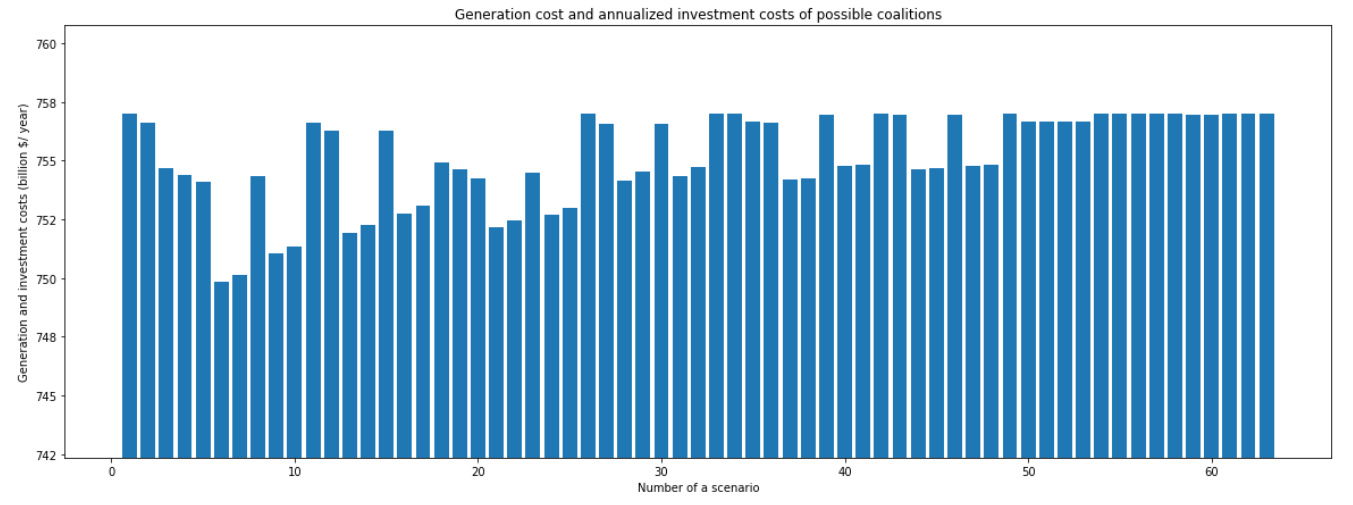

### 3. Modules used

In [2]:
function Shapley_matrix(n) #this function returns "u" Matrix of scenarios, not Shapley values

# n=3 #add number of players
B=zeros(2^n,n)

        #composing Basic Shapley Matrix B
        v=1
        ρ1=1
        ρ2=0
        P=zeros(n)
        for k=1:n #constructing the first column
            ρ=2^(n-k)
            ρ2=ρ2+ρ #global
            B[ρ1:ρ2,1].=v
            ρ1=ρ1+ρ #global
            v=v+1 #global
            P[k]=ρ2
        end

        for f=2:n #constructing the remaining columns
            ρρ1=2
            ρρ2=1
            for k=1:n
            ρρ2=floor(Int,P[k]+1)
            B[ρρ1:ρρ2,f]=view(B[ρρ2:2^n,f-1],1:ρρ2-ρρ1+1)
            ρρ1=floor(Int,P[k]+2)
            end
        end

        #repositioning of the elements
        B2=zeros(2^n,n)
        for i=1:2^n
            for j=1:n
                if floor(Int,B[i,j]) != 0
                B2[i,floor(Int,B[i,j])]=B[i,j]
                end
            end
        end
        # convert(Array{Int64}, B)

#constructing vectors with number of factors
Σ1=zeros(2^n,1)
Σ2=zeros(2^n,1)
gl=zeros(2^n,2)
gl0=zeros(2^n,2)
gl1=zeros(2^n,2)
gl2=zeros(2^n,2)
for i=1:2^n
    gl[i,1]=count(!iszero,B2[i,1:n])
    gl0[i,1]=gl[i,1]
    gl1[i,1]=gl0[i,1]-1
    gl2[i,1]=n-gl[i,1]-1
    Σ1[i,1]=maximum(gl1[i,:])
    Σ2[i,1]=maximum(gl2[i,:])
end

#composing a matrix of a non-missing elements
u=zeros(2^n,n)
for j=1:n
    for i=1:2^n
        if Int(B2[i,j]) != 0
                u[i,j]=1
        end
    end
end
u1=u.-1

#composing a matrix with coeficients M
# M=zeros(2^n,n)
# for i=1:2^n
#     for j=1:n
#         M[i,j]=(u[i,j]*factorial(Σ1[i])*factorial(n-Σ1[i]-1) + u1[i,j]*factorial(Σ2[i])*factorial(n-Σ2[i]-1))/factorial(n)
#     end
# end

# M=view(M,1:2^n-1,1:n) #throwing away the last raw

                    #  ------utility functions examples-------
# V=[5036.47, 15648.38, 33842.62, 28860.13, 10416.08, 23516.25, 18798.95] #X.Tan paper example
# V=[1, 10, 2] #two players gloves example
# V=[290.0, 211.026, 151.078, 211.026, 290.0, 309.026, 290.0] #my-3bus example
# V=[0, 1, 1, 1, 0, 0, 0] #3 playes veto example from coursera
# V=[0,60,80,80,80,40,80,20,0,60,80,40,0,20,0] #game#1 example from 1971 paper (4 players)
# V=[-40,10,50,0,0,0,-10,-50,10,50,40,0,0,-10,-50] #game#2 example from 1971 paper (4 players)


#here is the Shapley vector
# E=V'*M


return u
end


Shapley_matrix (generic function with 1 method)

In [3]:
function breaking_curves_new_data(k)

file=XLSX.readxlsx("ASG data 14.06.2018.xlsx")
# file=openxl("ASG data 12.07.2018 (Ru-Jp data).xlsx")
DP=XLSX.readdata("ASG data 14.06.2018.xlsx", "Curves", "C48:C56")# (old) peak power consumption forecast by 2035, GW
# DP=readxl(file,"Curves!C63:C71") # (new) peak power consumption forecast by 2035, GW
Seasons=XLSX.readdata("ASG data 14.06.2018.xlsx", "Curves", "B28:E36")#Seasonal changes in consumption
D=Seasons.*DP # power consumption by seasons, GW

# k=20 #number of breaking points
CostDeviation=0.05
GenMix=XLSX.readdata("ASG data 14.06.2018.xlsx", "Generation and costs", "B69:H77")# generation mix forecast by 2035, MW
LCOE=XLSX.readdata("ASG data 14.06.2018.xlsx", "Generation and costs", "B81:H89")# Variable power plant O&M cost, $/kWh

NewGenMix=zeros(getindex(size(GenMix[:,1]),1),k*getindex(size(GenMix[1,:]),1))
NewLCOE=zeros(getindex(size(LCOE[:,1]),1),k*getindex(size(LCOE[1,:]),1))
GenMixDeviation=zeros(getindex(size(GenMix[:,1]),1),getindex(size(GenMix[1,:]),1))
LCOEdeviation=zeros(getindex(size(LCOE[:,1]),1),getindex(size(LCOE[1,:]),1))
TypesMatrix=zeros(getindex(size(GenMix[:,1]),1),k*getindex(size(GenMix[1,:]),1)) #needed to remember types

for types=1:getindex(size(GenMix[1,:]),1)
    for nodes=1:getindex(size(GenMix[:,1]),1)
        GenMixDeviation[nodes,types]=GenMix[nodes,types]/k
        LCOEdeviation[nodes,types]=LCOE[nodes,types]*CostDeviation*2/k # a cost deviation step (the region is CostDeviation up and down)
    end
end


for nodes=1:getindex(size(GenMix[:,1]),1)
types=1; newtypes=1
    while types <= getindex(size(GenMix[1,:]),1)
        while newtypes <= k*getindex(size(GenMix[1,:]),1)
    fl=1
    δ=0

        while fl <= k
                # println(δ)
                    if fl==1
                        NewLCOE[nodes,newtypes]=LCOE[nodes,types]
                        NewLCOEstartingpoint=LCOE[nodes,types]
                    else
                        NewLCOE[nodes,newtypes]=NewLCOE[nodes,newtypes-1]+δ*LCOEdeviation[nodes,types]
                    end
            TypesMatrix[nodes,newtypes]=types
            NewGenMix[nodes,newtypes]=GenMixDeviation[nodes,types]
            fl=fl+1
            newtypes=newtypes+1

                if δ==0
                    δ=1
                else
                    δ=(abs(δ)+1)*(-1)*(abs(δ)/δ)
                end

        end
        types=types+1
        end

    end
end





# # -------------- Use this code to plot power market for a certain node ------
# using Plots
# gr()
# node=4 #select a node to plot data
#
# PlotMatrix=zeros(3,getindex(size(NewGenMix[1,:]),1))
# PlotMatrix[1,:]=NewGenMix[node,:]/1000 # mow in GW
# PlotMatrix[2,:]=NewLCOE[node,:]
# PlotMatrix[3,:]=TypesMatrix[node,:]
# SortedPlotMatrix=sortcols(PlotMatrix, by = x -> x[2])
#
# gencolor=0
# x1=0; x2=0; y1=0; y2=0
# for newtypes=1:getindex(size(NewGenMix[1,:]),1)
#     if SortedPlotMatrix[3,newtypes]==1
#         gencolor="orange"
#         labeltype="Nuclear"
#     elseif SortedPlotMatrix[3,newtypes]==2
#         gencolor="black"
#         labeltype="Coal"
#     elseif SortedPlotMatrix[3,newtypes]==3
#         gencolor="grey"
#         labeltype="Gas"
#     elseif SortedPlotMatrix[3,newtypes]==4
#         gencolor="red"
#         labeltype="Oil"
#     elseif SortedPlotMatrix[3,newtypes]==5
#         gencolor="blue"
#         labeltype="Hydro"
#     elseif SortedPlotMatrix[3,newtypes]==6
#         gencolor="green"
#         labeltype="RE"
#     elseif SortedPlotMatrix[3,newtypes]==7
#         gencolor="green"
#         labeltype="RE"
#     end
#
# x2=x1+SortedPlotMatrix[1,newtypes]
# y1=SortedPlotMatrix[2,newtypes]
# y2=y1
#     if newtypes==1
#         display(plot([x1,x2],[y1,y2],title="Variable O&M cost, USD/kWh",subplot=1,color=gencolor,w=5,legend=false,label=""))
#     end
#         display(plot!([x1,x2],[y1,y2],title="Variable O&M cost, USD/kWh",subplot=1,color=gencolor,w=5,legend=false,label=""))
#         # ylims!((0.0,0.31))
#         xlabel!("capacity, GW")
#         xlims!((0.0,350))
# x1=x2
# end
#
# display(plot!([0,0],[0,0],color=:green,label="RE",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:orange,label="Nuclear",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:black,label="Coal",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:grey,label="Gas",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:blue,label="Hydro",legend=true,w=3))
#
# #plotting demand
# for seasons=1:4
#     display(plot!([D[node,seasons],D[node,seasons]],[0,0.29],color=:black,label="",line=:dash))
#     println(D[node,seasons])
# end



# -------------- Use this code to plot power market for the whole region ------
# using Plots
# gr()
#
# display(plot([0,0],[0,0],color=:blue,label="Russia",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:red,label="Japan",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:orange,label="ROK",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:black,label="China",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:brown,label="Mongolia",legend=true,w=3))
# display(plot!([0,0],[0,0],color=:grey,label="DPRK",legend=true,w=3))
#
# for node=1:9
#
#     PlotMatrix=zeros(3,getindex(size(NewGenMix[1,:]),1))
#     PlotMatrix[1,:]=NewGenMix[node,:]/1000 # mow in GW
#     PlotMatrix[2,:]=NewLCOE[node,:]
#     PlotMatrix[3,:]=TypesMatrix[node,:]
#     SortedPlotMatrix=sortcols(PlotMatrix, by = x -> x[2])
#
#     gencolor=0
#     x1=0; x2=0; y1=0; y2=0
#     for newtypes=1:getindex(size(NewGenMix[1,:]),1)
#         if node==1
#             gencolor="blue"
#             labeltype="Russia"
#         elseif node==2
#             gencolor="blue"
#             labeltype="Russia"
#         elseif node==3
#             gencolor="blue"
#             labeltype="Russia"
#         elseif node==4
#             gencolor="red"
#             labeltype="Japan"
#         elseif node==5
#             gencolor="orange"
#             labeltype="ROK"
#         elseif node==6
#             gencolor="black"
#             labeltype="China"
#         elseif node==7
#             gencolor="black"
#             labeltype="China"
#         elseif node==8
#             gencolor="brown"
#             labeltype="Mongolia"
#         elseif node==9
#             gencolor="grey"
#             labeltype="DPRK"
#         end
#
#     x2=x1+SortedPlotMatrix[1,newtypes]
#     y1=SortedPlotMatrix[2,newtypes]
#     y2=y1
#     display(plot!([x1,x2],[y1,y2],title="LCOE, USD/kWh",subplot=1,color=gencolor,w=3,label=""))
#     ylims!((0.0,0.3))
#     xlims!((0.0,700))
#     xlabel!("capacity, GW")
#     x1=x2
#     end
# end


return  NewLCOE, NewGenMix
end


breaking_curves_new_data (generic function with 1 method)

In [4]:
function Shapley_value(n,V) ### FOR JULIA v1.1

# n=2 #add number of players
B=zeros(2^n,n)

        #composing Basic Shapley Matrix B
        v=1
        ρ1=1
        ρ2=0
        P=zeros(n)
        for k=1:n #constructing the first column
            ρ=2^(n-k)
            ρ2=ρ2+ρ #global
            B[ρ1:ρ2,1].=v
            ρ1=ρ1+ρ #global
            v=v+1 #global
            P[k]=ρ2
        end

        for f=2:n #constructing the remaining columns
            ρρ1=2
            ρρ2=1
            for k=1:n
            ρρ2=floor(Int,P[k]+1)
            B[ρρ1:ρρ2,f]=view(B[ρρ2:2^n,f-1],1:ρρ2-ρρ1+1)
            ρρ1=floor(Int,P[k]+2)
            end
        end

        #repositioning of the elements
        B2=zeros(2^n,n)
        for i=1:2^n
            for j=1:n
                if floor(Int,B[i,j]) != 0
                B2[i,floor(Int,B[i,j])]=B[i,j]
                end
            end
        end
        # convert(Array{Int64}, B)

#constructing vectors with number of factors
Σ1=zeros(2^n,1)
Σ2=zeros(2^n,1)
gl=zeros(2^n,2)
gl0=zeros(2^n,2)
gl1=zeros(2^n,2)
gl2=zeros(2^n,2)
for i=1:2^n
    gl[i,1]=count(!iszero,B2[i,1:n])
    gl0[i,1]=gl[i,1]
    gl1[i,1]=gl0[i,1]-1
    gl2[i,1]=n-gl[i,1]-1
    Σ1[i,1]=maximum(gl1[i,:])
    Σ2[i,1]=maximum(gl2[i,:])
end

#composing a matrix of a non-missing elements
u=zeros(2^n,n)
for j=1:n
    for i=1:2^n
        if Int(B2[i,j]) != 0
                u[i,j]=1
        end
    end
end
u1=u.-1

### composing a matrix with coeficients M
M=zeros(2^n,n)
for i=1:2^n
    for j=1:n
        M[i,j]=(u[i,j]*factorial(floor(Int,Σ1[i]))*factorial(floor(Int,n-Σ1[i]-1)) + u1[i,j]*factorial(floor(Int,Σ2[i]))*factorial(floor(Int,n-Σ2[i]-1)))/factorial(n)
    end
end

M=view(M,1:2^n-1,1:n) #throwing away the last raw

                    #  ------utility functions examples-------
# V=[5036.47, 15648.38, 33842.62, 28860.13, 10416.08, 23516.25, 18798.95] #X.Tan paper example
# V=[1, 10, 2] #two players gloves example
# V=[290.0, 211.026, 151.078, 211.026, 290.0, 309.026, 290.0] #my-3bus example
# V=[0, 1, 1, 1, 0, 0, 0] #3 playes veto example from coursera
# V=[0,60,80,80,80,40,80,20,0,60,80,40,0,20,0] #game#1 example from 1971 paper (4 players)
# V=[-40,10,50,0,0,0,-10,-50,10,50,40,0,0,-10,-50] #game#2 example from 1971 paper (4 players)



### here is the Shapley vector
E=V'*M


return E
end


Shapley_value (generic function with 1 method)